In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MAISI Inference Tutorial

This tutorial illustrates how to use trained MAISI model and codebase to generate synthetic 3D images and paired masks.

## Setup environment

In [14]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [22]:
import json
from monai.config import print_config
import argparse
from monai.utils import set_determinism
from scripts.utils import define_instance

print_config()

ImportError: cannot import name 'define_instance' from 'scripts.utils' (/mnt/drive1/canz/tutorials_infer/generative/maisi/scripts/utils.py)

## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in ./configs/environment.json

In [9]:
args = argparse.Namespace()

environment_file = "./configs/environment.json"
config_file = "./configs/config_maisi.json"
env_dict = json.load(open(environment_file, "r"))
config_dict = json.load(open(config_file, "r"))


for k, v in config_dict.items():
    setattr(args, k, v)
for k, v in env_dict.items():
    setattr(args, k, v)

## Set deterministic inference for reproducibility

In [12]:
set_determinism(42)

## Define network, scheduler, optimizer, and inferer

We will use a DDPM in this example; for that, we need to define a `DiffusionModelUNet` network that will have as input the noisy images and the values for the timestep `t`, and it will predict the noise that is present in the image.

In this example, we have a network with three levels (with 256, 256, and 512 channels in each). In every level, we will have two residual blocks, and only the last one will have an attention block with a single attention head (with 512 channels).

In [8]:
device = torch.device("cuda")

autoencoder = define_instance(args, "autoencoder_def").to(device)

### Visualization of the inference mask images

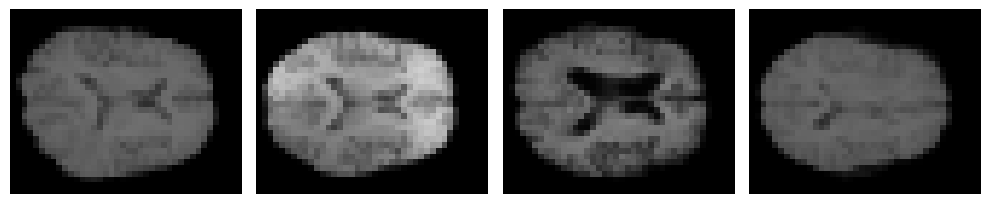

In [7]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

Together with our U-net, we need to define the Noise Scheduler for the diffusion model. This scheduler is responsible for defining the amount of noise that should be added in each timestep `t` of the diffusion model's Markov chain. Besides that, it has the operations to perform the reverse process, which will remove the noise of the images (a.k.a. denoising process). In this case, we are using a `DDPMScheduler`. Here we are using 1000 timesteps and a `scaled_linear` profile for the beta values (proposed in [Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752)). This profile had better results than the `linear, proposed in the original DDPM's paper. In `beta_start` and `beta_end`, we define the limits for the beta values. These are important to determine how accentuated is the addition of noise in the image.

In [ ]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

Finally, we define the Inferer, which contains functions that will help during the training and sampling of the model, and the optimizer.

In [ ]:
inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)